Learning Objectives

- Read MODIS data in HDF4 format into Python using open source packages (xarray).
- Extract metadata from HDF4 files.
- Plot data extracted from HDF4 files.

In this lesson, you will learn how to **open a MODIS HDF4 format file using xarray.**

In [2]:
# Import packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep

warnings.simplefilter('ignore')

# Get the MODIS data
et.data.get_data('cold-springs-modis-h4')

# This download is for the fire boundary
et.data.get_data('cold-springs-fire')

# Set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Extracted output to C:\Users\34639\earth-analytics\data\cold-springs-modis-h4\.


## Hierarchical Data Formats - HDF4 - EOS in Python
You can use rioxarray to open HDF4 data. Note that both tools wrap around gdal and will make the code needed to open your HDF4 data, simpler.



To begin, create a path to your HDF4 file.

In [3]:
# Create a path to the pre-fire MODIS h4 data
modis_pre_path = os.path.join("cold-springs-modis-h4",
                              "07_july_2016",
                              "MOD09GA.A2016189.h09v05.006.2016191073856.hdf")
modis_pre_path

'cold-springs-modis-h4\\07_july_2016\\MOD09GA.A2016189.h09v05.006.2016191073856.hdf'

## Open HDF4 Files Using Open Source Python and Xarray
HDF files are hierarchical and self describing (the metadata is contained within the data). Because the data are hierarchical, you will have to loop through the main dataset and the subdatasets nested within the main dataset to access the reflectance data (the bands) and the qa layers.

Below you open the HDF4 file. Notice that rioxarray
returns a list rather than an single xarray object. Within that list are two xarray objects representing the two groups in the h4 file.

In [4]:
# Open data with rioxarray
modis_pre = rxr.open_rasterio(modis_pre_path,masked=True)
type(modis_pre)

list

In [8]:
#modis_pre

The first object returned in the list contains all of the quality control layers. Notice that each layer is stored as a data variable.

In [5]:
# This is just a data exploration step
modis_pre_qa = modis_pre[0]
modis_pre_qa

<xarray.Dataset>
Dimensions:               (band: 1, x: 1200, y: 1200)
Coordinates:
  * y                     (y) float64 4.447e+06 4.446e+06 ... 3.336e+06
  * x                     (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
  * band                  (band) int32 1
    spatial_ref           int32 0
Data variables:
    num_observations_1km  (band, y, x) float32 ...
    granule_pnt_1         (band, y, x) float32 ...
    state_1km_1           (band, y, x) float32 ...
    SensorZenith_1        (band, y, x) float32 ...
    SensorAzimuth_1       (band, y, x) float32 ...
    Range_1               (band, y, x) float32 ...
    SolarZenith_1         (band, y, x) float32 ...
    SolarAzimuth_1        (band, y, x) float32 ...
    gflags_1              (band, y, x) float32 ...
    orbit_pnt_1           (band, y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

**You can access a data variable in a similar fashion to how you would access a column in a pandas DataFrame using the ["variable-name-here"]**.

In [10]:
modis_pre_qa["granule_pnt_1"]

<xarray.DataArray 'granule_pnt_1' (band: 1, y: 1200, x: 1200)>
[1440000 values with dtype=float32]
Coordinates:
  * y            (y) float64 4.447e+06 4.446e+06 ... 3.337e+06 3.336e+06
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.897e+06 -8.896e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Granule Pointer - first layer
    units:         none

The second element in the list contains the reflectance data. This is the data that you will want to use for your analysis

In [11]:
# Reflectance data
modis_pre_bands = modis_pre[1]
modis_pre_bands

<xarray.Dataset>
Dimensions:                (band: 1, x: 2400, y: 2400)
Coordinates:
  * y                      (y) float64 4.448e+06 4.447e+06 ... 3.336e+06
  * x                      (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
  * band                   (band) int32 1
    spatial_ref            int32 0
Data variables:
    num_observations_500m  (band, y, x) float32 ...
    sur_refl_b01_1         (band, y, x) float32 ...
    sur_refl_b02_1         (band, y, x) float32 ...
    sur_refl_b03_1         (band, y, x) float32 ...
    sur_refl_b04_1         (band, y, x) float32 ...
    sur_refl_b05_1         (band, y, x) float32 ...
    sur_refl_b06_1         (band, y, x) float32 ...
    sur_refl_b07_1         (band, y, x) float32 ...
    QC_500m_1              (band, y, x) float64 ...
    obscov_500m_1          (band, y, x) float32 ...
    iobs_res_1             (band, y, x) float32 ...
    q_scan_1               (band, y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

## Subset Data By Group or Variable
If you need to open the entire dataset, you can follow the steps above. Alternatively you can specific subgroups or even layers / variables
in the data to open specifically using the **group=** parameter.

There are a few ways to get the group names. One manual way is to use the HDF4 tool (or something like panoply) to view the
groups. You could also use something like gdalinfo or rasterio to loop through groups and subgroups.

The files with this pattern in the name:

**sur_refl_b01_1**

are the bands which contain surface reflectance data.

- sur_refl_b01_1: MODIS Band One
- sur_refl_b02_1: MODIS Band Two

etc.

Notice that there are some other layers in the file as well including the state_1km layer which contains the QA (cloud and quality assurance) information.

In [12]:
# Use rasterio to print all of the subdataset names in the data
# Here you can see the group names: MODIS_Grid_500m_2D & MODIS_Grid_1km_2D
import rasterio as rio
with rio.open(modis_pre_path) as groups:
    for name in groups.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:num_observations_1km
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:granule_pnt_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:num_observations_500m
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h4\07_july_2016\MOD09G

Below you actually open the data subsetting first by

- 1.group and then
- 2.by variable names

In [13]:
# Subset by group only - Notice you have all bands in the returned object
rxr.open_rasterio(modis_pre_path,
                  masked=True,
                  group="MODIS_Grid_500m_2D").squeeze()

<xarray.Dataset>
Dimensions:                (x: 2400, y: 2400)
Coordinates:
  * y                      (y) float64 4.448e+06 4.447e+06 ... 3.336e+06
  * x                      (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
    band                   int32 1
    spatial_ref            int32 0
Data variables:
    num_observations_500m  (y, x) float32 ...
    sur_refl_b01_1         (y, x) float32 ...
    sur_refl_b02_1         (y, x) float32 ...
    sur_refl_b03_1         (y, x) float32 ...
    sur_refl_b04_1         (y, x) float32 ...
    sur_refl_b05_1         (y, x) float32 ...
    sur_refl_b06_1         (y, x) float32 ...
    sur_refl_b07_1         (y, x) float32 ...
    QC_500m_1              (y, x) float64 ...
    obscov_500m_1          (y, x) float32 ...
    iobs_res_1             (y, x) float32 ...
    q_scan_1               (y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

Subset by a list of variable names.

In [15]:
# Open just the bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]
# Notice that here, you get a single xarray object with just the bands that
# you want to work with
modis_pre_bands = rxr.open_rasterio(modis_pre_path, variable=desired_bands).squeeze()
modis_pre_bands

<xarray.Dataset>
Dimensions:         (x: 2400, y: 2400)
Coordinates:
  * y               (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x               (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band            int32 1
    spatial_ref     int32 0
Data variables:
    sur_refl_b01_1  (y, x) int16 ...
    sur_refl_b02_1  (y, x) int16 ...
    sur_refl_b03_1  (y, x) int16 ...
    sur_refl_b04_1  (y, x) int16 ...
    sur_refl_b07_1  (y, x) int16 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [16]:
#  view nodata value
modis_pre_bands.sur_refl_b01_1.rio.nodata

-28672

## Handle NoData Using Masked=True
If you look at the MODIS documentation table that is in the Introduction to MODIS chapter, you will see that the range of value values for MODIS spans from -100 to 16000. There is also a fill or no data value -28672 to consider. By using the masked=True parameter when you open the data, you mask all pixels that are nodata.

Below you open the data and mask no data values using masked=True. Notice that once you apply the mask, the nodata value
attribute is erased from the object.

In [17]:
# Open just the bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]
# Notice that here, you get a single xarray object with just the bands that
# you want to work with
modis_pre_bands = rxr.open_rasterio(modis_pre_path,
                                    masked=True,
                                    variable=desired_bands).squeeze()
modis_pre_bands

<xarray.Dataset>
Dimensions:         (x: 2400, y: 2400)
Coordinates:
  * y               (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x               (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band            int32 1
    spatial_ref     int32 0
Data variables:
    sur_refl_b01_1  (y, x) float32 ...
    sur_refl_b02_1  (y, x) float32 ...
    sur_refl_b03_1  (y, x) float32 ...
    sur_refl_b04_1  (y, x) float32 ...
    sur_refl_b07_1  (y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [18]:
# Now your nodata value returns a NAN as it has been masked
# and accounted for
modis_pre_bands.sur_refl_b01_1.rio.nodata

nan

## Process MODIS Bands Stored in a HDF4 File
Xarray has several built in plot methods making it easy to explore your data. Below you plot the first band.

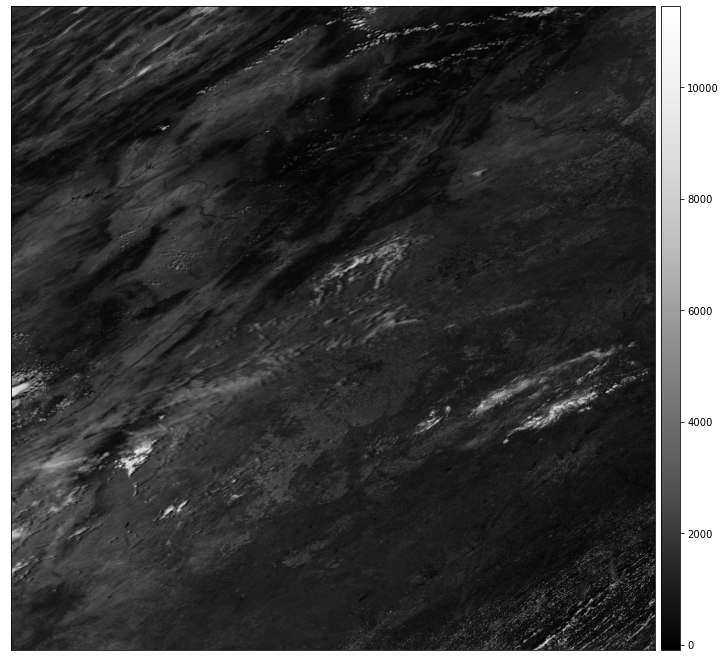

In [19]:
# Plot band one of the data
ep.plot_bands(modis_pre_bands.sur_refl_b01_1)
plt.show()

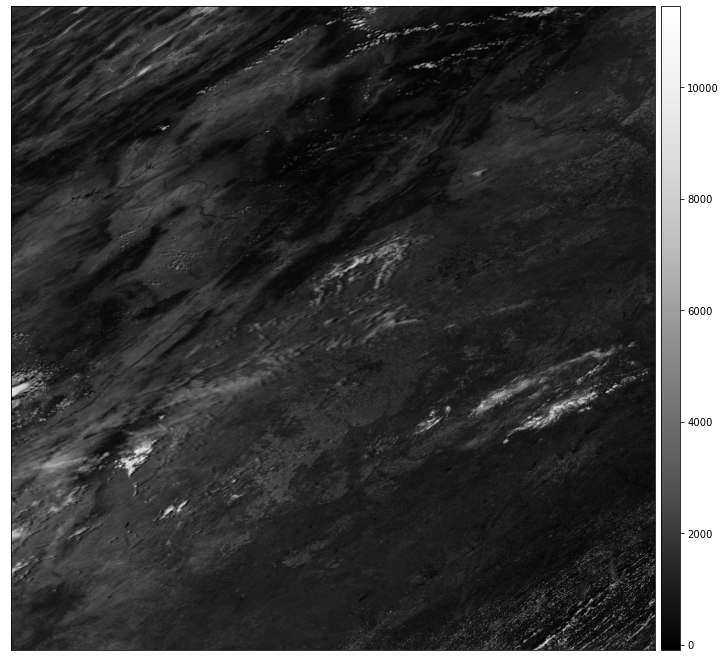

In [20]:
# Note that you can also call the data variable by name
ep.plot_bands(modis_pre_bands["sur_refl_b01_1"])
plt.show()

## Plot All MODIS Bands with EarthPy
Now that you have the needed reflectance data, you can plot your data using earthpy.plot_bands.

To plot all bands in the data, you will need to first create an Xarray DataArray object.

In [21]:
print(type(modis_pre_bands))
print(type(modis_pre_bands.to_array()))

# You can plot each band easily using a data array object
modis_pre_bands.to_array()

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray (variable: 5, y: 2400, x: 2400)>
array([[[1902., 1949., 1947., ..., 1327., 1327., 1181.],
        [1949., 2160., 2095., ..., 1327., 1273., 1273.],
        [2054., 2156., 2187., ..., 1139., 1101., 1206.],
        ...,
        [1387., 1469., 1469., ...,  343.,  499., 1006.],
        [1298., 1316., 1469., ...,  905.,  499.,  436.],
        [1316., 1316., 1454., ...,  905.,  578.,  351.]],

       [[2714., 2859., 3041., ..., 3046., 3046., 4421.],
        [2968., 3362., 3253., ..., 3046., 4550., 4550.],
        [3198., 3315., 3246., ..., 4178., 4017., 3992.],
        ...,
        [2911., 2947., 2947., ..., 4059., 4907., 3799.],
        [2954., 2890., 2947., ..., 4517., 4907., 3459.],
        [2890., 2890., 2935., ..., 4517., 3728., 4021.]],

       [[1056., 1072., 1012., ...,  745.,  745.,  581.],
        [1051., 1150., 1039., ...,  745.,  595.,  595.],
        [1073., 1220., 1152., ...,  588.,  564.,  563.],
        ...,
        [ 759.,  813.,  813., ...,  150.,  218.,  852.],
        [ 703.,  735.,  813., ...,  585.,  218.,  199.],
        [ 735.,  735.,  798., ...,  585.,  338.,  109.]],

       [[1534., 1567., 1527., ..., 1107., 1107., 1069.],
        [1548., 1776., 1665., ..., 1107., 1121., 1121.],
        [1696., 1813., 1820., ..., 1029., 1018., 1077.],
        ...,
        [1209., 1267., 1267., ...,  597.,  788., 1153.],
        [1165., 1154., 1267., ..., 1089.,  788.,  603.],
        [1154., 1154., 1231., ..., 1089.,  759.,  516.]],

       [[2781., 2692., 2801., ..., 2260., 2260., 1534.],
        [2792., 2705., 2684., ..., 2260., 1449., 1449.],
        [2747., 2754., 2733., ..., 1713., 1802., 1548.],
        ...,
        [2457., 2446., 2446., ...,  444.,  832., 1379.],
        [2289., 2296., 2446., ..., 1161.,  832.,  762.],
        [2296., 2296., 2511., ..., 1161.,  913.,  703.]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band         int32 1
    spatial_ref  int32 0
  * variable     (variable) <U14 'sur_refl_b01_1' ... 'sur_refl_b07_1'
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

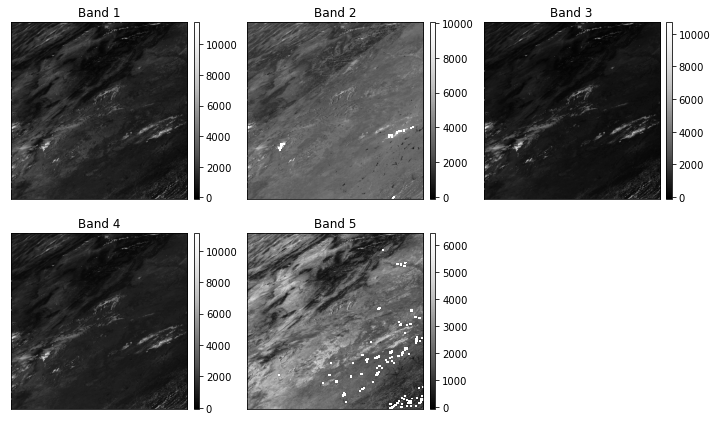

In [22]:
# Plot the data as a DataArray
# This is only a data exploration step
ep.plot_bands(modis_pre_bands.to_array().values,
              figsize=(10, 6))
plt.show()

## RGB Image of MODIS Data Using EarthPy
Once you have cleaned your data cleaned, you can plot an RGB image using earthpy.

In [23]:
# Select the rgb bands only
rgb_bands = ['sur_refl_b01_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1']
# Turn the data into a DataArray
modis_rgb_xr = modis_pre_bands[rgb_bands].to_array()
modis_rgb_xr

<xarray.DataArray (variable: 3, y: 2400, x: 2400)>
array([[[1902., 1949., 1947., ..., 1327., 1327., 1181.],
        [1949., 2160., 2095., ..., 1327., 1273., 1273.],
        [2054., 2156., 2187., ..., 1139., 1101., 1206.],
        ...,
        [1387., 1469., 1469., ...,  343.,  499., 1006.],
        [1298., 1316., 1469., ...,  905.,  499.,  436.],
        [1316., 1316., 1454., ...,  905.,  578.,  351.]],

       [[1056., 1072., 1012., ...,  745.,  745.,  581.],
        [1051., 1150., 1039., ...,  745.,  595.,  595.],
        [1073., 1220., 1152., ...,  588.,  564.,  563.],
        ...,
        [ 759.,  813.,  813., ...,  150.,  218.,  852.],
        [ 703.,  735.,  813., ...,  585.,  218.,  199.],
        [ 735.,  735.,  798., ...,  585.,  338.,  109.]],

       [[1534., 1567., 1527., ..., 1107., 1107., 1069.],
        [1548., 1776., 1665., ..., 1107., 1121., 1121.],
        [1696., 1813., 1820., ..., 1029., 1018., 1077.],
        ...,
        [1209., 1267., 1267., ...,  597.,  788., 1153.],
        [1165., 1154., 1267., ..., 1089.,  788.,  603.],
        [1154., 1154., 1231., ..., 1089.,  759.,  516.]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band         int32 1
    spatial_ref  int32 0
  * variable     (variable) <U14 'sur_refl_b01_1' ... 'sur_refl_b04_1'
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [24]:
def clean_array_plot(xr_obj):
    # This function takes a single xarray object as an input and produces a
    # cleaned numpy array output for plotting
    # BEGIN SOLUTION
    """
    Take an  xarray object and replace null  values with a mask for plotting

    Parameters
    ----------
    xr_obj : xarray object

    Returns
    -------
    A masked numpy array 

    """
    # END SOLUTION

    return ma.masked_array(xr_obj.values,  xr_obj.isnull())

In [25]:
# For plotting you will want to clean up masked values
# Note that this is not a numpy array
modis_arr = clean_array_plot(modis_rgb_xr)
modis_arr

masked_array(
  data=[[[1902.0, 1949.0, 1947.0, ..., 1327.0, 1327.0, 1181.0],
         [1949.0, 2160.0, 2095.0, ..., 1327.0, 1273.0, 1273.0],
         [2054.0, 2156.0, 2187.0, ..., 1139.0, 1101.0, 1206.0],
         ...,
         [1387.0, 1469.0, 1469.0, ..., 343.0, 499.0, 1006.0],
         [1298.0, 1316.0, 1469.0, ..., 905.0, 499.0, 436.0],
         [1316.0, 1316.0, 1454.0, ..., 905.0, 578.0, 351.0]],

        [[1056.0, 1072.0, 1012.0, ..., 745.0, 745.0, 581.0],
         [1051.0, 1150.0, 1039.0, ..., 745.0, 595.0, 595.0],
         [1073.0, 1220.0, 1152.0, ..., 588.0, 564.0, 563.0],
         ...,
         [759.0, 813.0, 813.0, ..., 150.0, 218.0, 852.0],
         [703.0, 735.0, 813.0, ..., 585.0, 218.0, 199.0],
         [735.0, 735.0, 798.0, ..., 585.0, 338.0, 109.0]],

        [[1534.0, 1567.0, 1527.0, ..., 1107.0, 1107.0, 1069.0],
         [1548.0, 1776.0, 1665.0, ..., 1107.0, 1121.0, 1121.0],
         [1696.0, 1813.0, 1820.0, ..., 1029.0, 1018.0, 1077.0],
         ...,
         [1209.

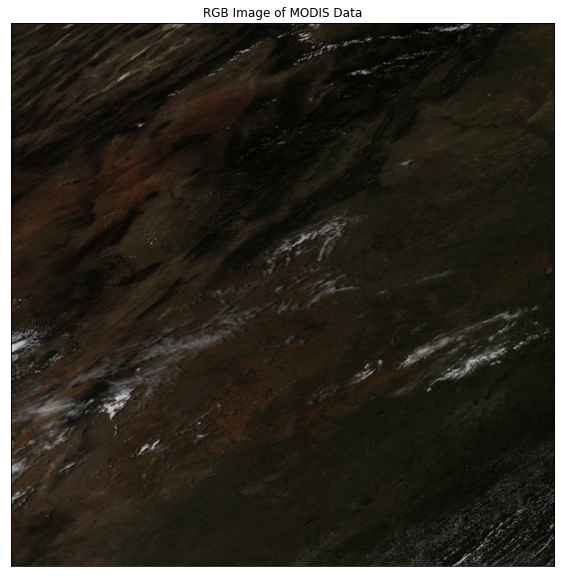

In [28]:
# Plot MODIS RGB numpy image array
ep.plot_rgb(modis_arr,
            rgb=[0, 2, 1],
            title='RGB Image of MODIS Data')

plt.show()

## Crop (Clip) MODIS Data Using Rioxarray
Above you opened and plotted MODIS reflectance data. However, the data cover a larger study area than you need. It is a good idea to crop your the data to maximize processing efficiency. Less pixels means less
processing time and power needed.

There are a few approaches here to consider

- 1.Do you want to clip the data to a box (a rectangular extent) vs to the specific geometry of your shapefile
- 2.If your data are large and you have limited memory, you may only want to open the data needed for processing.

Below you have a few different options for clipping your data. To demonstrate the full workflow, we will s tart over and open the data.

To begin, open up the fire boundary which contains your study area extent that you wish to crop your MODIS data to co_cold_springs_20160711_2200_dd83.shp).

In [29]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# Check the CRS of your study area extent
fire_boundary.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

### Reproject the Clip Extent (Fire Boundary)
To check the CRS of MODIS data, you can:

- 1.Open the MODIS data in rioxarray
- 2.Grab the CRS of the band accessing rio.crs from the rioxarray object.
You can also use rasterio to “view” and access the CRS

You can then use the CRS of the band to check and reproject the fire boundary if it is not in the same CRS.

In the code below, you use these steps to reproject the fire boundary to match the HDF4 data.

Note that you do not need all of the print statments included below. They are included to help you see what is happening in the code!

In [30]:
# Check CRS
if not fire_boundary.crs == modis_rgb_xr.rio.crs:
    # If the crs is not equal reproject the data
    fire_bound_sin = fire_boundary.to_crs(modis_rgb_xr.rio.crs)

fire_bound_sin.crs

<Projected CRS: PROJCS["unnamed",GEOGCS["Unknown datum based upon  ...>
Name: unnamed
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Sinusoidal
Datum: Not specified (based on custom spheroid)
- Ellipsoid: Custom spheroid
- Prime Meridian: Greenwich

## Scenario 1: Open and Clip the Data Using the CRS=Parameter
In the first scenario obelow, you open and clip your data. By using the crs= parameter, you can skip needing to reproject the clip extent as rioxarray does it for you.

The caveat too this approach is that it is generally slower than the other approaches. The benefit is it avoids the additional reprojection step.

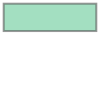

In [31]:
# Notice this is a box - representing the spatial extent
# of your study area
crop_bound_box = [box(*fire_boundary.total_bounds)]
crop_bound_box[0]

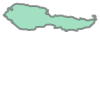

In [32]:
# Notice that this is the actual shape of the fire boundary
# First you need to decide whether you want to clip to the
# Box /  extent (above) or the shape that you see here.
fire_boundary.geometry[0]

Below you clip the data to the box extent.

A few notes on each parameter included below

**open_rasterio** parameters:

- **masked=True** : This masks out no data values for you
- **variable=** : Allows you to select data variables to open effectively subsetting or slicing out only the parts of the data that you need.

**rio.clip parameters**

- **crs=** : Use this if your crop extent is in a different CRS than your raster xarray data. NOTE that this can slow your processing down significantly.
- **all_touched=** : Set to True if you want to include all pixels touched by your crop boundary. Sometimes the edge of a shapefile will cross over a pixel making it a “partial” pixel. Do you want to include all pixels even if only some of that pixel is in your study area? IF so set to True. If you only with to include pixels that are FULLY WITHIN your study area set to False.
- **from_disk** : Include this to only OPEN the data that you wish to work with. Thus instead of opening up the entire raster and then clipping, the data within the clip boundary are “sliced” out. this saves memory and sometimes processing time!

In [33]:
# Open just the bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]

#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*fire_boundary.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
modis_pre_clip = rxr.open_rasterio(modis_pre_path,
                                   masked=True,
                                   variable=desired_bands).rio.clip(crop_bound_box,
                                                                    crs=fire_boundary.crs,
                                                                    # Include all pixels even partial pixels
                                                                    all_touched=True,
                                                                    from_disk=True).squeeze()
# The final clipped data
modis_pre_clip

<xarray.Dataset>
Dimensions:         (x: 12, y: 3)
Coordinates:
  * y               (y) float64 4.446e+06 4.446e+06 4.445e+06
  * x               (x) float64 -8.989e+06 -8.989e+06 ... -8.985e+06 -8.984e+06
    band            int32 1
    spatial_ref     int32 0
Data variables:
    sur_refl_b01_1  (y, x) float32 nan nan 428.0 450.0 ... 458.0 nan nan nan
    sur_refl_b02_1  (y, x) float32 nan nan 3.013e+03 2.809e+03 ... nan nan nan
    sur_refl_b03_1  (y, x) float32 nan nan 259.0 235.0 ... 265.0 nan nan nan
    sur_refl_b04_1  (y, x) float32 nan nan 563.0 541.0 ... 518.0 nan nan nan
    sur_refl_b07_1  (y, x) float32 nan nan 832.0 820.0 ... 804.0 nan nan nan
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [34]:
# For demonstration purpposes  i'm creating a plotting extent
from rasterio.plot import plotting_extent

modis_ext = plotting_extent(modis_pre_clip.to_array().values[0],
                            modis_pre_clip.rio.transform())

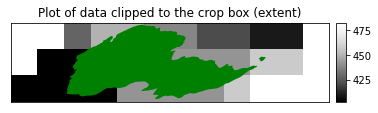

In [35]:
# View cropped data
f, ax = plt.subplots()
ep.plot_bands(modis_pre_clip.to_array().values[0],
              ax=ax,
              extent=modis_ext,
              title="Plot of data clipped to the crop box (extent)")
fire_bound_sin.plot(ax=ax,
                    color="green")
plt.show()

## Scenario 2: Crop Using the GEOMETRY
In the scenario below you crop / mask the data to the actual geometry shape of the fire boundary. Because the MODIS pixels are larger and the study area is relative small, you can’t visually see a difference however you will see a difference with landsat and other higher resolution data.



In [36]:
# Open just the bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]

#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*fire_boundary.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
modis_pre_clip_geom = rxr.open_rasterio(modis_pre_path,
                                   masked=True,
                                   variable=desired_bands).rio.clip(fire_boundary.geometry.apply(mapping),
                                                                    crs=fire_boundary.crs,
                                                                    # Include all pixels even partial pixels
                                                                    all_touched=True,
                                                                    from_disk=True).squeeze()
# The final clipped data  -  Notice there are fewer pixels
# In the output object
modis_pre_clip_geom

<xarray.Dataset>
Dimensions:         (x: 8, y: 3)
Coordinates:
  * y               (y) float64 4.446e+06 4.446e+06 4.445e+06
  * x               (x) float64 -8.988e+06 -8.988e+06 ... -8.986e+06 -8.985e+06
    band            int32 1
    spatial_ref     int32 0
Data variables:
    sur_refl_b01_1  (y, x) float32 428.0 450.0 450.0 438.0 ... 442.0 458.0 nan
    sur_refl_b02_1  (y, x) float32 3.013e+03 2.809e+03 ... 2.496e+03 nan
    sur_refl_b03_1  (y, x) float32 259.0 235.0 235.0 231.0 ... 230.0 265.0 nan
    sur_refl_b04_1  (y, x) float32 563.0 541.0 541.0 528.0 ... 476.0 518.0 nan
    sur_refl_b07_1  (y, x) float32 832.0 820.0 820.0 820.0 ... 789.0 804.0 nan
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

Note that the difference between the two plots will be more visible when using data like landsat with smaller pixels.

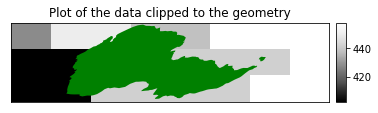

In [37]:
# View cropped data  - note the  different b etew
f, ax = plt.subplots()
ep.plot_bands(modis_pre_clip_geom.to_array().values[0],
              ax=ax,
              extent=modis_ext,
              title="Plot of the data clipped to the geometry")
fire_bound_sin.plot(ax=ax,
                    color="green")
plt.show()

## Scenario 3: Crop MODIS Data Using Reprojected Fire Boundary
In the example below, you skip the crs= argument.
This has assumed that yoou have already reprojected your
vector crop extent.

In this example the clip function is not chained to the open_rasterio function making the proccessing a bit less efficient. More data will be stored in memory in this example.

Once you have opened and reprojected your crop extent, you can crop your MODIS raster data. You can do this by calling xarray_name.rio.clip([box(*boundary_name.total_bounds)]). Keep in mind, for this to work you have to import box from shapely.geometry!

In [38]:
# Open the data but don't clip just yet
modis_bands = rxr.open_rasterio(modis_pre_path,
                                masked=True,
                                variable=desired_bands)

# Reproject the fire boundary
fire_boundary_sin = fire_boundary.to_crs(modis_bands.rio.crs)

modis_bands_clip = modis_bands.rio.clip([box(*fire_bound_sin.total_bounds)],
                                        all_touched=True,
                                        from_disk=True).squeeze()
modis_bands_clip

<xarray.Dataset>
Dimensions:         (x: 8, y: 3)
Coordinates:
  * y               (y) float64 4.446e+06 4.446e+06 4.445e+06
  * x               (x) float64 -8.988e+06 -8.988e+06 ... -8.986e+06 -8.985e+06
    band            int32 1
    spatial_ref     int32 0
Data variables:
    sur_refl_b01_1  (y, x) float32 428.0 450.0 450.0 438.0 ... 442.0 458.0 458.0
    sur_refl_b02_1  (y, x) float32 3.013e+03 2.809e+03 ... 2.496e+03 2.496e+03
    sur_refl_b03_1  (y, x) float32 259.0 235.0 235.0 231.0 ... 230.0 265.0 265.0
    sur_refl_b04_1  (y, x) float32 563.0 541.0 541.0 528.0 ... 476.0 518.0 518.0
    sur_refl_b07_1  (y, x) float32 832.0 820.0 820.0 820.0 ... 789.0 804.0 804.0
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

The output plot looks similar, yet the processing approach is
different

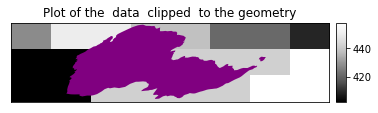

In [40]:
# View cropped data
f, ax = plt.subplots()
ep.plot_bands(modis_bands_clip.to_array().values[0],
              ax=ax,
              extent=modis_ext,
              title="Plot of the  data  clipped  to the geometry")
fire_bound_sin.plot(ax=ax,
                    color="purple")
plt.show()

## Which Approach To Use?
you may be wondering which of the above scenarios is best. The answer is - it depends. We know that using the crs= parameter will likely slow down your processing, however it requires less code to implement.

For small workflows it could be find to use the approach that uses the least amount of code. For other workflows, you may want to reproject your fire boundary first and use either .clip (or clip_box) to clip your data.

Hopefully the examples above get your started in the right direction and you can customize your workflow to your science goals and processing needs!

## Putting it Together Efficiently
This entire workflow above can be consolidated into an efficient
function. Below is a function that combines many of the items discussed above. Note that this function does incorporate the
crs= parameter which could slow processing down a bit.

In [41]:
def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    """Open, subset and crop a MODIS h4 file.

    Parameters
    -----------
    band_path : string 
        A path to the array to be opened.
    crop_bound : geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
        A tuple of min and max range of values for the data. Default = None.
    variable : List
        A list of variables to be opened from the raster.

    Returns
    -----------
    band : xarray DataArray
        Cropped xarray DataArray
    """

    crop_bound_box = [box(*crop_bound.total_bounds)]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable).rio.clip(crop_bound_box,
                                                             crs=crop_bound.crs,
                                                             all_touched=True,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

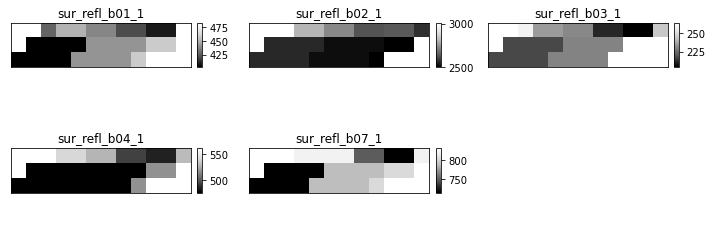

In [42]:
# Open bands with function
clean_bands = open_clean_bands(band_path=modis_pre_path,
                               crop_bound=fire_boundary,
                               valid_range=(0, 10000),
                               variable=desired_bands)

# Plot bands opened with function
ep.plot_bands(clean_bands.to_array().values,
              title=desired_bands,
              figsize=(10, 4))

plt.show()

## Export MODIS Data as a GeoTIFF
You can quickly export a .tif file using rioxarray. To
do this you need a path to the new file that includes the new file name. Rioxarray will create a .tif file with all the correct data and metadata.

In [43]:
# Define path and file name for new tif file
stacked_file_path = os.path.join(os.path.dirname(modis_pre_path),
                                 "final_output",
                                 "modis_band_1.tif")

# Get the directory needed for the defined path
modis_dir_path = os.path.dirname(stacked_file_path)
print("Directory to save path:", modis_dir_path)

# Create the directory if it does not exist
if not os.path.exists(modis_dir_path):
    os.mkdir(modis_dir_path)
    print("The directory", modis_dir_path, "does not exist - creating it now.")

Directory to save path: cold-springs-modis-h4\07_july_2016\final_output
The directory cold-springs-modis-h4\07_july_2016\final_output does not exist - creating it now.


You can now export or write out a new GeoTIFF file.

In [44]:
# Here you decide how much of the data you want to export.
# A single layer vs a stacked / array
# Export a single band to a geotiff
clean_bands.rio.to_raster(stacked_file_path)

Open and view your stacked GeoTIFF.

In [45]:
# Open the file to make sure it looks ok
modis_b1_xr = rxr.open_rasterio(stacked_file_path,
                                masked=True)

modis_b1_xr.rio.crs, modis_b1_xr.rio.nodata

(CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 None)

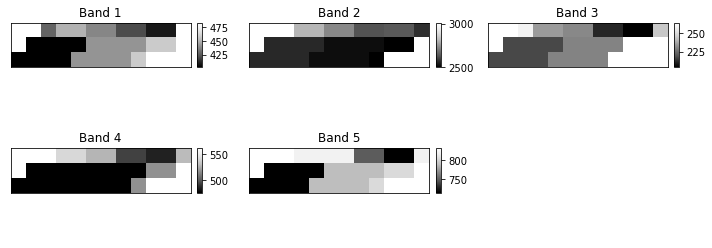

In [46]:
# Plot the data
ep.plot_bands(modis_b1_xr,
              figsize=(10, 4))

plt.show()

Plot of each MODIS band in the numpy stack cropped to the cold springs fire extent, identical to the last plot showing this same thing.